# Projet viager

Émilien Schultz - 9/04/2025

Objectif : faire une approximation de la valeur au m2 d'un bien à partir de sa localisation

- à partir d'une liste d'adresses, les géolocaliser
- calculer à partir des transactions autour de ce bien une moyenne du m2


## Questions ouvertes

- quels jeux de données : 2024, ou plus ?
- comment fixer les paramètres (rayon, seuil du nombre d'éléments)
- comment filtrer les outlayers dans les biens
- vérifier dans les prédidictions les cas limites (cohérence avec les adresses)
- être sur que le calcul du prix du m2 a du sens (sens de la surface surface_reelle_bati)

Application :

- https://explore.data.gouv.fr/fr/immobilier?onglet=carte&filtre=tous&lat=48.86123&lng=2.28116&zoom=16.97&level=parcelle&code=75116000DK0041

Données ouvertes disponibles : 

- https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/

## Remarques générales

- Pas de donneés pour Alsace/Lorraine

## Chargement des bibliothèques 

(les installer avant)

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import yaml

# pour la géolocalisation
import googlemaps

## Exploration des données

Chargement et mise sous forme géographiques 

In [3]:
df = pd.read_csv("./data/full2024.csv", low_memory=False)
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # WGS 84
gdf.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,geometry
0,2024-1,2024-01-02,1,Vente,346.5,NaN,NaN,LE DELIVRE,B020,1230.0,...,NaN,NaN,P,prés,NaN,NaN,99.0,5.530952,45.952439,POINT (5.53095 45.95244)
1,2024-2,2024-01-03,2,Vente,10000.0,NaN,NaN,CHEVRY DESSOUS,B007,1170.0,...,NaN,NaN,S,sols,NaN,NaN,115.0,6.043339,46.282256,POINT (6.04334 46.28226)
2,2024-3,2024-01-08,1,Vente,249000.0,NaN,NaN,PIN HAMEAU,B086,1290.0,...,NaN,NaN,S,sols,NaN,NaN,497.0,4.911143,46.247235,POINT (4.91114 46.24724)
3,2024-4,2024-01-03,1,Vente,329500.0,29.0,NaN,PL DU JURA,0500,1170.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,6.058695,46.332212,POINT (6.05870 46.33221)
4,2024-4,2024-01-03,1,Vente,329500.0,29.0,NaN,PL DU JURA,0500,1170.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,6.058695,46.332212,POINT (6.05870 46.33221)


In [3]:
gdf.loc[6]

id_mutation                                         2024-4
date_mutation                                   2024-01-03
numero_disposition                                       1
nature_mutation                                      Vente
valeur_fonciere                                   329500.0
adresse_numero                                        29.0
adresse_suffixe                                        NaN
adresse_nom_voie                                PL DU JURA
adresse_code_voie                                     0500
code_postal                                         1170.0
code_commune                                         01173
nom_commune                                            Gex
code_departement                                        01
ancien_code_commune                                    NaN
ancien_nom_commune                                     NaN
id_parcelle                                 01173000AI0551
ancien_id_parcelle                                     N

In [112]:
gdf["valeur_fonciere"].describe()

count    1.549589e+06
mean     5.851872e+05
std      3.246600e+06
min      1.500000e-01
25%      5.000000e+04
50%      1.485000e+05
75%      2.860000e+05
max      2.550000e+08
Name: valeur_fonciere, dtype: float64

In [113]:
gdf["surface_reelle_bati"].describe()

count    482832.000000
mean        116.663939
std         874.660282
min           1.000000
25%          48.000000
50%          74.000000
75%         103.000000
max      265000.000000
Name: surface_reelle_bati, dtype: float64

Calcul du prix au m2 par bien

In [4]:
gdf["prixm2"] = gdf["valeur_fonciere"] / gdf["surface_reelle_bati"]

In [5]:
bornes = gdf["prixm2"].quantile([0.05, 0.95])
bornes.values

array([  545.97729094, 20356.03174603])

### Définition des critères de filtre

Valeurs d'intérêt
- valeur_fonciere
- surface_reelle_bati

Filtres

- nature_mutation == Vente
- type_local in ["Maison", "Appartement"]

Enlever les outliers : prix de moins de 500e/m2, prix de plus de 20000 euros/m2

In [6]:
f1 = (gdf["nature_mutation"] == "Vente")
f2 = (gdf["type_local"] == "Maison") | (gdf["type_local"] == "Appartement")
f3 = gdf["valeur_fonciere"].notna()
f4 = gdf["surface_reelle_bati"].notna()
bornes = gdf["prixm2"].quantile([0.05, 0.95])
f5 = (gdf["prixm2"] > bornes.values[0]) & (gdf["prixm2"] < bornes.values[1])
f = f1 & f2 & f3 & f4 & f5

# sample
gdf_ss = gdf[f]
gdf_ss.shape

(398155, 42)

Carte des biens vendus

Text(0.5, 1.0, 'Distribution nationale des prix au m2 des transactions pour 2024')

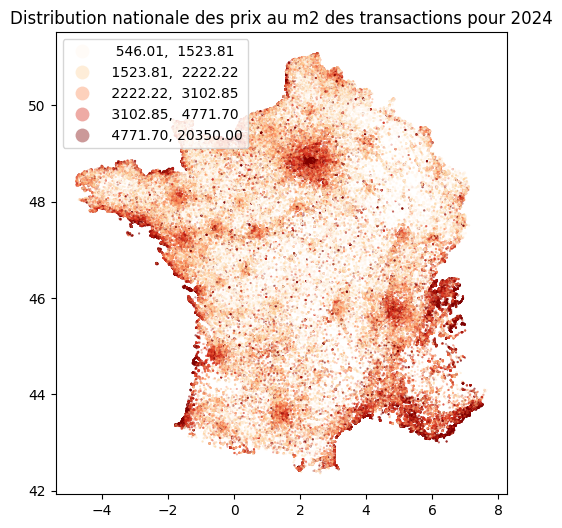

In [7]:
f = (gdf_ss["latitude"] > 40) & (gdf_ss["latitude"] < 60) & (gdf_ss["longitude"] > -5) & (gdf_ss["longitude"] < 8)

fig, ax = plt.subplots(figsize=(8, 6)) 
gdf_ss[f].plot(column = "prixm2", legend=True, marker='.', alpha=0.4, markersize=1, ax=ax, cmap='OrRd', scheme='quantiles')
plt.title("Distribution nationale des prix au m2 des transactions pour 2024")

## Géolocalisation des données

Avec googlemaps, définition d'une fonction (besoin d'une clé : https://developers.google.com/maps/documentation/javascript/get-api-key?hl=fr)

In [24]:
# add a file with the key
key = yaml.safe_load(open("credentials.yml","r"))["key"]

gmaps = googlemaps.Client(key=key)

def get_geoloc(adresse: str):
    """
    Get geoloc adress
    """
    geocode_result = gmaps.geocode(adresse)
    if geocode_result:
        location = geocode_result[0]['geometry']['location']
        lat, lng = location['lat'], location['lng']
        return (lat, lng)
    else:
        return None

On teste sur un exemple

In [31]:
coord = get_geoloc("7 Rue Louis David, Paris")
coord

(48.8616641, 2.2814703)

### Application sur toutes les adresses

Récupérer pour toutes les données, appliquer la géolocalisation, et décomposer en deux colonnes latitude et longitude

In [6]:
adresses = pd.read_stata("./data/donnees_viager.dta")
geoloc = adresses["adresse_bien_vendu"].apply(get_geoloc)
adresses["latitude"] = geoloc.apply(lambda x: x[0] if x else None)
adresses["longitude"] = geoloc.apply(lambda x: x[1] if x else None)
adresses.to_csv("./data/adresses_geoloc.csv", index=False)

Création du fichier `adresses_geoloc.csv`

Charger fichier

In [90]:
df_adresses = pd.read_csv("./data/adresses_geoloc.csv")
df_adresses["geometry"] = df_adresses.apply(lambda row : Point(row["longitude"], row["latitude"]), axis=1)
df_adresses.head()

,adresse_bien_vendu,numero,nb_pieces,mettres_carres,latitude,longitude,geometry
0,"84 rue Pouchet, 75017, Paris",1178,1.0,32.0,48.896745,2.322817,POINT (2.3228173 48.89674489999999)
1,"32 avenue Matignon, 75008, Paris",1180,2.0,45.0,48.872063,2.314564,POINT (2.3145637 48.87206339999999)
2,"41 rue des 3 Frères, 75018, Paris",1186,2.0,25.0,48.885118,2.339644,POINT (2.3396438 48.8851176)
3,"6 avenue Simon Bolivar, 75019, Paris",1194,2.0,37.0,48.874083,2.384925,POINT (2.3849249 48.8740825)
4,"48 rue de l'Ermitage, 75020, Paris",1199,3.0,69.3,48.872106,2.393150,POINT (2.3931499 48.8721055)


Récupérer les ventes "autour"

In [84]:
# Convert in Mercator (meters)
gdf = gdf_ss.to_crs(epsg=3857) 

point = gpd.GeoSeries([Point(coord[1],coord[0])], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]

# Create a circular zone
buffer = point.buffer(100)

# Filter elements within the buffer
gdf_within = gdf[gdf.geometry.intersects(buffer)]

# Display result
gdf_within

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,geometry,prixm2
1547273,2024-547298,2024-01-19,1,Vente,1059870.0,8.0,NaN,RUE LOUIS DAVID,5776,75016.0,...,2.0,NaN,NaN,NaN,NaN,NaN,2.281121,48.861936,POINT (253933.228 6251467.209),17094.677419


Définir une fonction qui récupère au moins X ventes autour d'une adresse avec comme seuil fixé le nombre minimal d'éléments à garder et une augmentation croissante du rayon de recherche avec un step `step` 

In [105]:
def get_n_transactions_around(point: Point, 
                              gdf: gpd.GeoDataFrame, 
                              n = 10, 
                              step = 10):
    """
    Get n transactions around a point
    """
    point = gpd.GeoSeries([point], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]
    gdf_filter = None
    radius = 100
    while gdf_filter is None or gdf_filter.shape[0] < n:
        buffer = point.buffer(radius)
        gdf_filter = gdf[gdf.geometry.intersects(buffer)]
        if gdf_filter.shape[0] >= n:
            break
        else:
            radius = radius + step
    return (gdf_filter["prixm2"].mean(), gdf_filter["prixm2"].std(), radius, len(gdf_filter))

In [91]:
get_n_transactions_around(Point(2.2814703, 48.8616641), gdf, n = 10, multiplicator = 2)

(11480.599614648967, 3063.515258578315, 320)

In [92]:
get_n_transactions_around(Point(2.3396438, 48.8851176), gdf, n = 10, multiplicator = 2)

(10877.31855605384, 2334.9172872348836, 160)

In [74]:
df_adresses

,adresse_bien_vendu,numero,nb_pieces,mettres_carres,latitude,longitude,geometry
0,"84 rue Pouchet, 75017, Paris",1178,1.0,32.00,48.896745,2.322817,POINT (48.89674489999999 2.3228173)
1,"32 avenue Matignon, 75008, Paris",1180,2.0,45.00,48.872063,2.314564,POINT (48.87206339999999 2.3145637)
2,"41 rue des 3 Frères, 75018, Paris",1186,2.0,25.00,48.885118,2.339644,POINT (48.8851176 2.3396438)
3,"6 avenue Simon Bolivar, 75019, Paris",1194,2.0,37.00,48.874083,2.384925,POINT (48.8740825 2.3849249)
4,"48 rue de l'Ermitage, 75020, Paris",1199,3.0,69.30,48.872106,2.393150,POINT (48.8721055 2.3931499)
...,...,...,...,...,...,...,...
789,"11bis avenue de Ségur, 75007, Paris",99996,3.0,102.26,48.852296,2.311087,POINT (48.8522964 2.311087)
790,"365 rue de Vaugirard, 75015, Paris",99997,2.0,NaN,48.836462,2.295270,POINT (48.836462 2.29527)
791,"17 rue d'Odessa, 75014, Paris",99998,4.0,65.20,48.842025,2.324751,POINT (48.8420255 2.3247512)
792,"179 avenue d'Argenteuil, 92600, Asnières",99999,NaN,NaN,48.918559,2.280918,POINT (48.9185592 2.2809178)


In [106]:
tmp = df_adresses["geometry"].apply(lambda x : get_n_transactions_around(x, gdf))
df_adresses["prixm2"] = tmp.apply(lambda x : x[0])
df_adresses["prixm2_std"] = tmp.apply(lambda x : x[1])
df_adresses["prixm2_radius"] = tmp.apply(lambda x : x[2])
df_adresses["prixm2_num"] = tmp.apply(lambda x : x[3])

In [122]:
df_adresses.head()

,adresse_bien_vendu,numero,nb_pieces,mettres_carres,latitude,longitude,geometry,prixm2,prixm2_std,prixm2_radius,prixm2_num
0,"84 rue Pouchet, 75017, Paris",1178,1.0,32.0,48.896745,2.322817,POINT (2.3228173 48.89674489999999),8740.156357,1273.316435,140,10
1,"32 avenue Matignon, 75008, Paris",1180,2.0,45.0,48.872063,2.314564,POINT (2.3145637 48.87206339999999),12125.434169,3129.485020,270,10
2,"41 rue des 3 Frères, 75018, Paris",1186,2.0,25.0,48.885118,2.339644,POINT (2.3396438 48.8851176),9757.169966,1869.475773,120,11
3,"6 avenue Simon Bolivar, 75019, Paris",1194,2.0,37.0,48.874083,2.384925,POINT (2.3849249 48.8740825),9173.027401,1531.450216,110,10
4,"48 rue de l'Ermitage, 75020, Paris",1199,3.0,69.3,48.872106,2.393150,POINT (2.3931499 48.8721055),8261.668256,1825.049460,280,10


In [111]:
df_adresses["prixm2_radius"].describe()

count     794.000000
mean      257.506297
std       424.225817
min       100.000000
25%       150.000000
50%       190.000000
75%       250.000000
max      6680.000000
Name: prixm2_radius, dtype: float64

In [121]:
df_adresses.head()

,adresse_bien_vendu,numero,nb_pieces,mettres_carres,latitude,longitude,geometry,prixm2,prixm2_std,prixm2_radius,prixm2_num
0,"84 rue Pouchet, 75017, Paris",1178,1.0,32.0,48.896745,2.322817,POINT (2.3228173 48.89674489999999),8740.156357,1273.316435,140,10
1,"32 avenue Matignon, 75008, Paris",1180,2.0,45.0,48.872063,2.314564,POINT (2.3145637 48.87206339999999),12125.434169,3129.485020,270,10
2,"41 rue des 3 Frères, 75018, Paris",1186,2.0,25.0,48.885118,2.339644,POINT (2.3396438 48.8851176),9757.169966,1869.475773,120,11
3,"6 avenue Simon Bolivar, 75019, Paris",1194,2.0,37.0,48.874083,2.384925,POINT (2.3849249 48.8740825),9173.027401,1531.450216,110,10
4,"48 rue de l'Ermitage, 75020, Paris",1199,3.0,69.3,48.872106,2.393150,POINT (2.3931499 48.8721055),8261.668256,1825.049460,280,10


In [120]:
df_adresses.drop(columns=["geometry"]).to_stata("data/adresses_enrichies.dta")
df_adresses.drop(columns=["geometry"]).to_csv("data/adresses_enrichies.csv")

## Carte avec les adresses sur les adresses sur Paris.

In [19]:
adresses = pd.read_csv("data/adresses_enrichies.csv")
adresses['geometry'] = adresses.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
adresses = gpd.GeoDataFrame(adresses, geometry='geometry', crs="EPSG:4326")  # WGS 84

Shapefile de la région parisienne

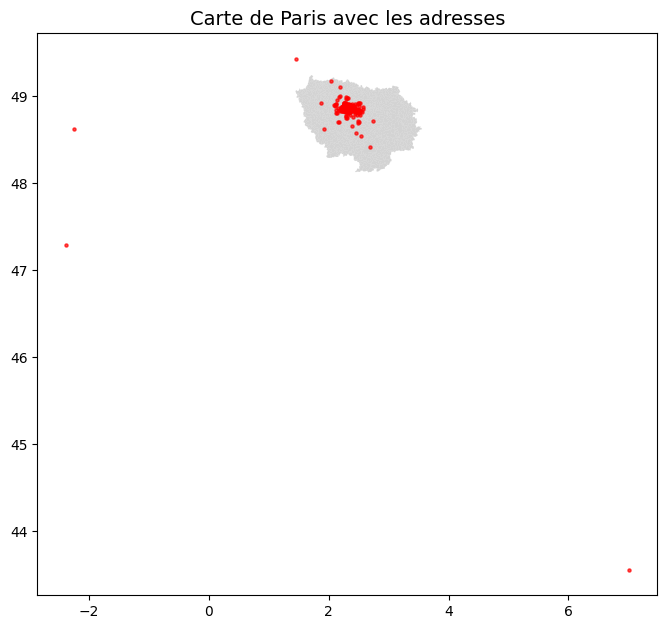

In [31]:
fix, ax = plt.subplots(1, 1, figsize=(8, 8))
paris = gpd.read_file("./data/communes-dile-de-france-au-01-janvier/communes-dile-de-france-au-01-janvier.shp")
paris.plot(ax=ax, color='lightgrey', edgecolor='lightgrey', linewidth=0.1)
adresses.plot(ax=ax, color='red', markersize=5, alpha=0.7)  # Plus petit, légèrement transparent
ax.set_title("Carte de Paris avec les adresses", fontsize=14)
plt.show()